# Multi-Class Classifier

## Load data

In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'df_discovery.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'df_validation.pkl').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=0)

## Preprocess data

### Exclude categories with <10 samples

In [3]:
# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]

In [4]:
df['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           360
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             201
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                198
AML with other rare recurring translocations                              172
AML with mutated NPM1                                                     172
MDS-related or secondary myeloid neoplasms                                158
Otherwise-Normal Control                                                  121
AML with in-frame bZIP mutated CEBPA                                       69
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   31
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     27
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement     10
Name: count, dtype: int64

### Exclude samples with missing labels

In [5]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

### Define X and y

In [6]:

# Define X and y
X = df[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=1399, n_features=5)
y = df['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

# Split the data into train/test sets based on the `Train Test` column
X_train = X[df['Train Test']=='Discovery (train) Samples']
y_train = y[df['Train Test']=='Discovery (train) Samples']
X_test = X[df['Train Test']=='Validation (test) Samples']
y_test = y[df['Train Test']=='Validation (test) Samples']

## Gaussian Process

In [7]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Fit/predict
gpc = GaussianProcessClassifier(multi_class='one_vs_rest', random_state=42, n_jobs=-1)
_ = gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)
y_pred_proba = gpc.predict_proba(X_test)

# Evaluate
from sklearn.metrics import accuracy_score

print(f'Accuracy score: {accuracy_score(y_test, y_pred):.3f}')

Accuracy score: 0.867


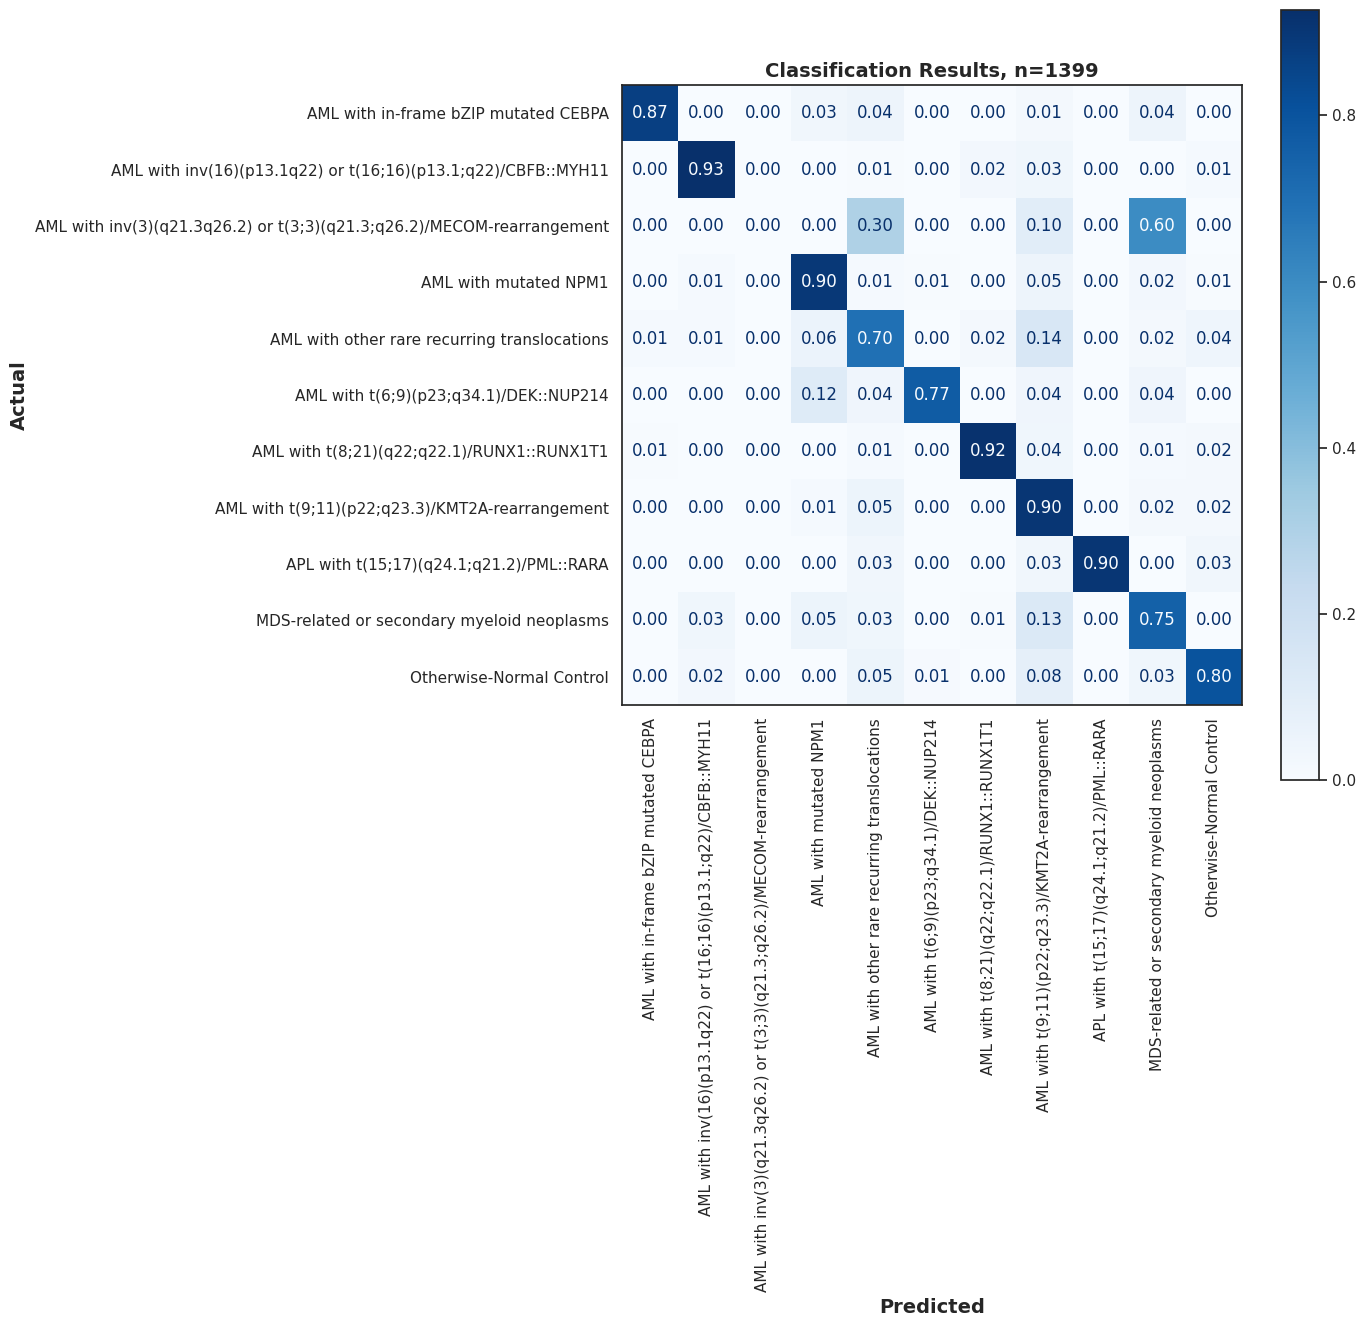

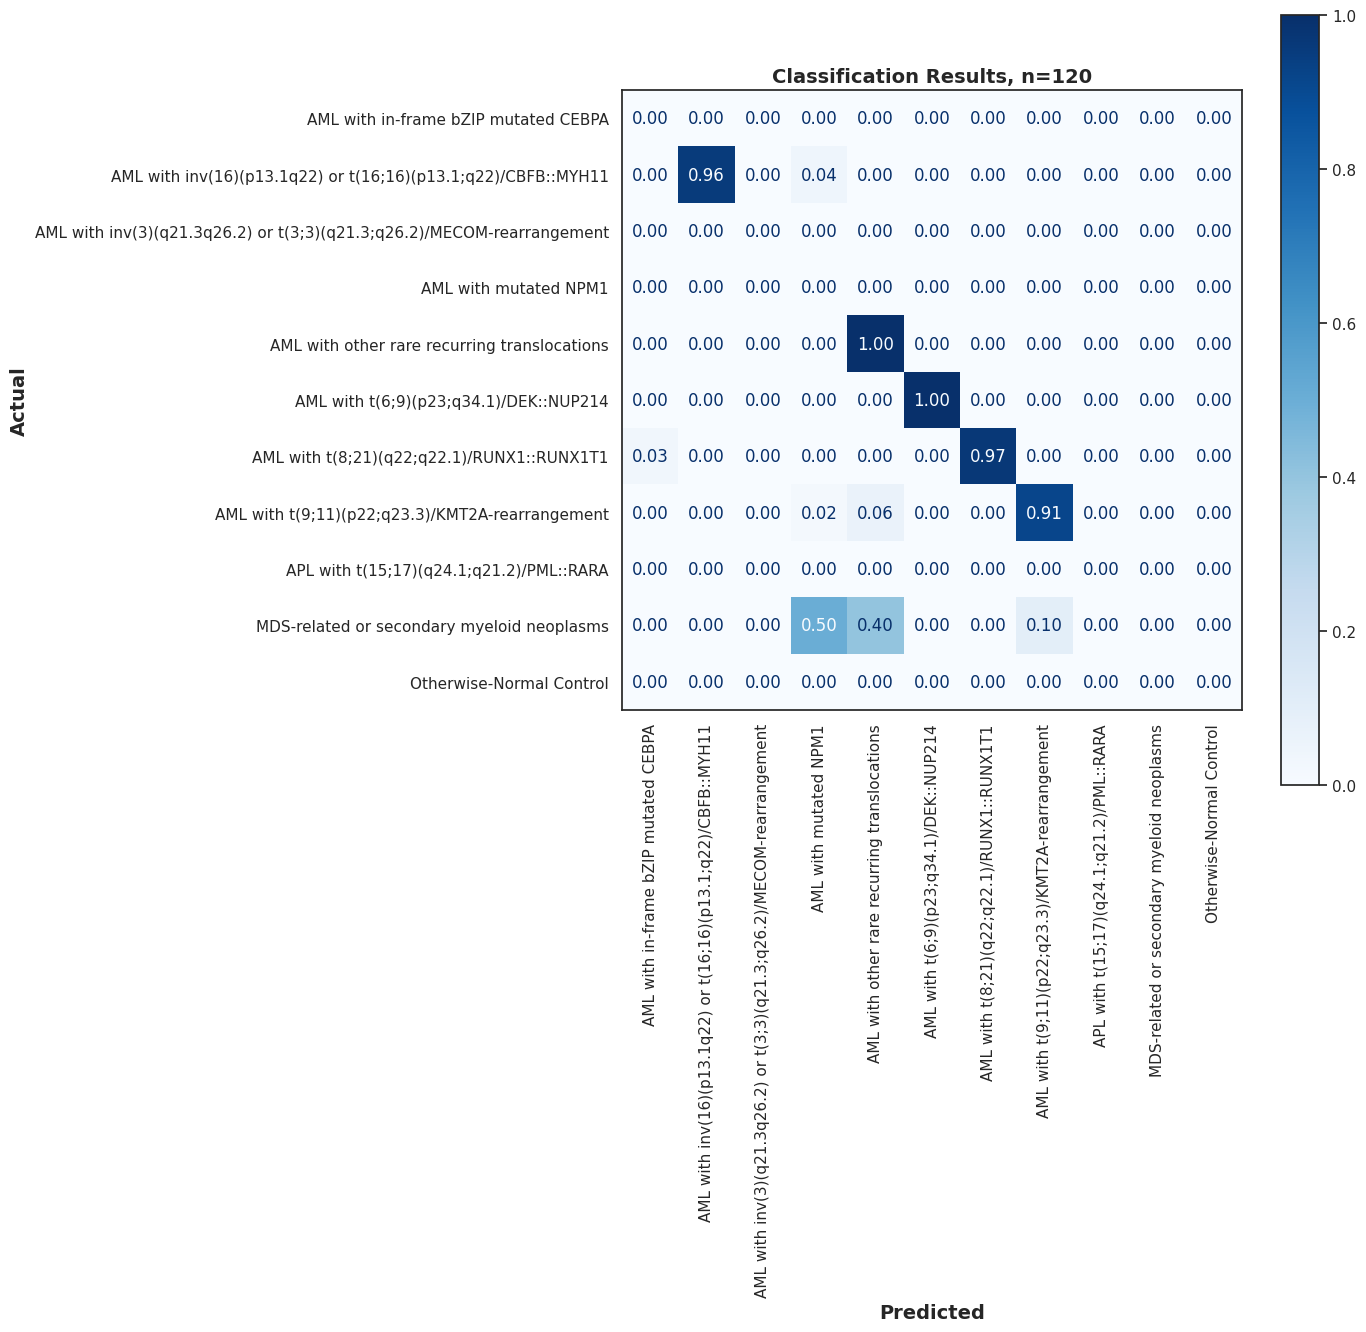

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(clf, x_test, y_test):
    sns.set_theme(style='white')
    predictions = clf.predict(x_test)
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical')

    # Increase the size of the plot
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

    # Add title and axis names
    plt.title('Classification Results, n=' + str(len(x_test)), fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')

    plt.show()

plot_confusion_matrix(gpc, X_train, y_train)
plot_confusion_matrix(gpc, X_test, y_test)

## Deep Learning

In [11]:
# One hot encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

## Define model architecture

[5 inputs] -> [10 hidden neurons] -> [11 outputs]

In [12]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True)

class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(10, 20)
        self.act = nn.ReLU()
        self.output = nn.Linear(20, 11)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

# loss metric and optimizer
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 100
batch_size = 5
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

ModuleNotFoundError: No module named 'torch'

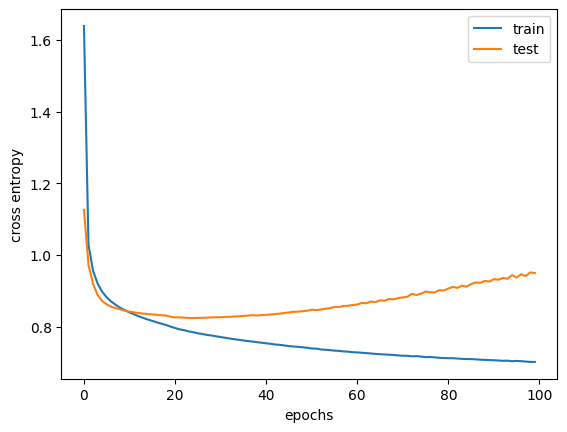

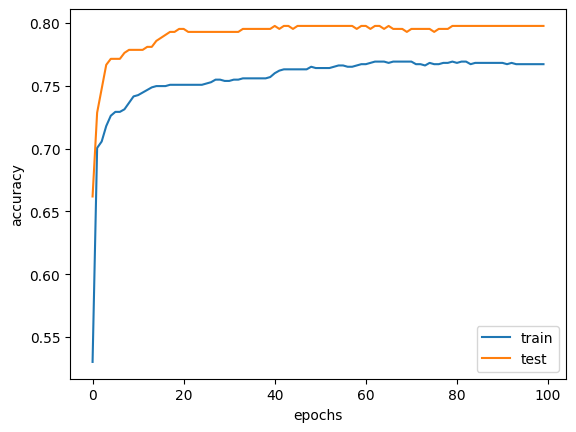

In [ ]:

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, label_encoder):
    sns.set_theme(style='white')

    # Make sure the model is in evaluation mode
    model.eval()

    # Compute the model predictions
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = torch.argmax(y_pred, 1)

    # Convert tensors to NumPy arrays for use with sklearn
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.cpu().numpy()

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical')

    # Increase the size of the plot
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

    # Add title and axis names
    plt.title('Classification Results, n=' + str(len(X_test)), fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')

    plt.show()

plot_confusion_matrix(model, X_test, y_test, label_encoder)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets